In [1]:
import numpy as np
import os
import torch
import json
from sklearn.preprocessing import OneHotEncoder
from tqdm.auto import tqdm
import glob

c:\Users\caleb\anaconda3\envs\cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
READ_FILE = 'hands_valid.json'
RANKMAP = {'A':1, 'T':10, 'J':11, 'Q':12, 'K':13}
SUITMAP = {'c':1, 'd':2, 'h':3, 's':4}

In [3]:
def encode_hand_numerical(card_list):
    rank_list = [card[0] for card in card_list]
    suit_list = [card[1] for card in card_list]
    def encode_rank_numerical(ranks):
        return np.vectorize(lambda x: x if x not in RANKMAP.keys() else RANKMAP[x])(np.array(ranks)).reshape(-1,1)
    def encode_suit_numerical(suits):
        return np.vectorize(lambda x: SUITMAP[x])(np.array(suits)).reshape(-1,1)
    encoded_ranks = encode_rank_numerical(rank_list).astype(int)
    encoded_suits = encode_suit_numerical(suit_list).astype(int)
    return np.concatenate((encoded_ranks, encoded_suits), axis=1)


In [4]:
def encode_hand_hot(card_list):
    suits = 'cdhs'  # clubs, diamonds, hearts, spades
    ranks = 'A23456789TJQK'
    all_cards = [rank + suit for rank in ranks for suit in suits]
    card_encoder = OneHotEncoder(categories=[all_cards])
    return card_encoder.fit_transform(np.array(card_list).reshape(-1,1)).toarray()

In [5]:
def encode_board(card_list, rounds, full_ohe=True):
    '''
    Returns an encoding of the board that hides cards that the dealer hasn't revealed yet

    Parameters:
    card_list: list of all five cards on the board
    rounds: one-hot encoding of the game's rounds. rows equal to number of rounds, 4 columns (for pre-flop, flop, turn, river)
    one_hot_ranks, one_hot_suits: see encode_hand

    Returns:
    submatrix ready to be added to the overall encoding. Number of rows depends on embedding choice, number of columns
    equal to the number of rounds
    '''
    full_board = encode_hand_numerical(card_list)
    board_list = []
    if(torch.is_tensor(rounds)):
        rounds = rounds.numpy().T
    for round in rounds:
        if(round[0] == 1):
            board_list.append(np.zeros(full_board.shape).flatten().reshape(-1, 1))
        elif(round[1] == 1):
            flop = full_board[:3]
            hidden = np.zeros((2, full_board.shape[1]))
            board_list.append(np.concatenate((flop, hidden)).flatten().reshape(-1,1))
        elif(round[2] == 1):
            flop_turn = full_board[:4]
            hidden = np.zeros((1, full_board.shape[1]))
            board_list.append(np.concatenate((flop_turn, hidden)).flatten().reshape(-1,1))
        else:
            board_list.append(full_board.flatten().reshape(-1,1))
    return np.concatenate(board_list, axis=1)

In [6]:
def encode_bets(bets):
    '''
    One-hot encodes the rounds of the game (pre-flop, flop, turn, and river) as well as the many
    actions a SINGLE player has made. i.e., we need to call this once per player
    '''
    round_encoder = OneHotEncoder(categories=[['p', 'f', 't', 'r']])
    action_encoder = OneHotEncoder(categories=[['-', 'B', 'f', 'k', 'b', 'c', 'r', 'A', 'Q', 'K']])
    round_list, action_list = [], []
    for round in bets:
        for action in round['actions']:
            round_list.append(round['stage'])
            action_list.append(action)
    rounds = round_encoder.fit_transform(np.array(round_list).reshape(-1, 1)).toarray()
    actions = action_encoder.fit_transform(np.array(action_list).reshape(-1,1)).toarray()
    return rounds, actions

In [7]:
MAXIMUM_SIZE = 20

In [8]:
# with open('hands_valid.json', 'r') as f_in:
#     with open('hands_filtered.json', 'w') as f_out:
#         for line in tqdm(f_in):
#             data = json.loads(line)
#             if(data['num_players'] == 2):
#                 action_count = 0
#                 for round in data['players'][0]['bets']:
#                     action_count += len(round['actions'])
#                 for round in data['players'][1]['bets']:
#                     action_count += len(round['actions'])
#                 if(action_count <= MAXIMUM_SIZE):
#                     f_out.write(line)

In [9]:
with open('hands_filtered.json', 'r') as file:
    bankrolls = []
    actions = []
    winnings = []
    pots = []
    for line in tqdm(file):
            data = json.loads(line)
            for player in range(2):
                bankrolls.append(data['players'][player]['bankroll'])
                actions.append(data['players'][player]['action'])
                winnings.append(data['players'][player]['winnings'])
            for inner_dict in data['pots']:
                 pots.append(inner_dict['size'])

367055it [00:04, 90936.96it/s]


In [10]:
log_bankrolls, log_actions, log_winnings, log_pots = np.log(np.array(bankrolls) + 1), np.log(np.array(actions) + 1), np.log(np.array(winnings) + 1), np.log(np.array(pots) + 1)
std_scl_arr = [(x - np.mean(x))/np.std(x) for x in [log_bankrolls, log_actions, log_winnings, log_pots]]
mean_sd_dict = {}
for dataset, data_str in zip([log_bankrolls, log_actions, log_winnings, log_pots], ['bankroll', 'action', 'winnings', 'pot']):
    mean_sd_dict[data_str] = (np.mean(dataset), np.std(dataset))

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

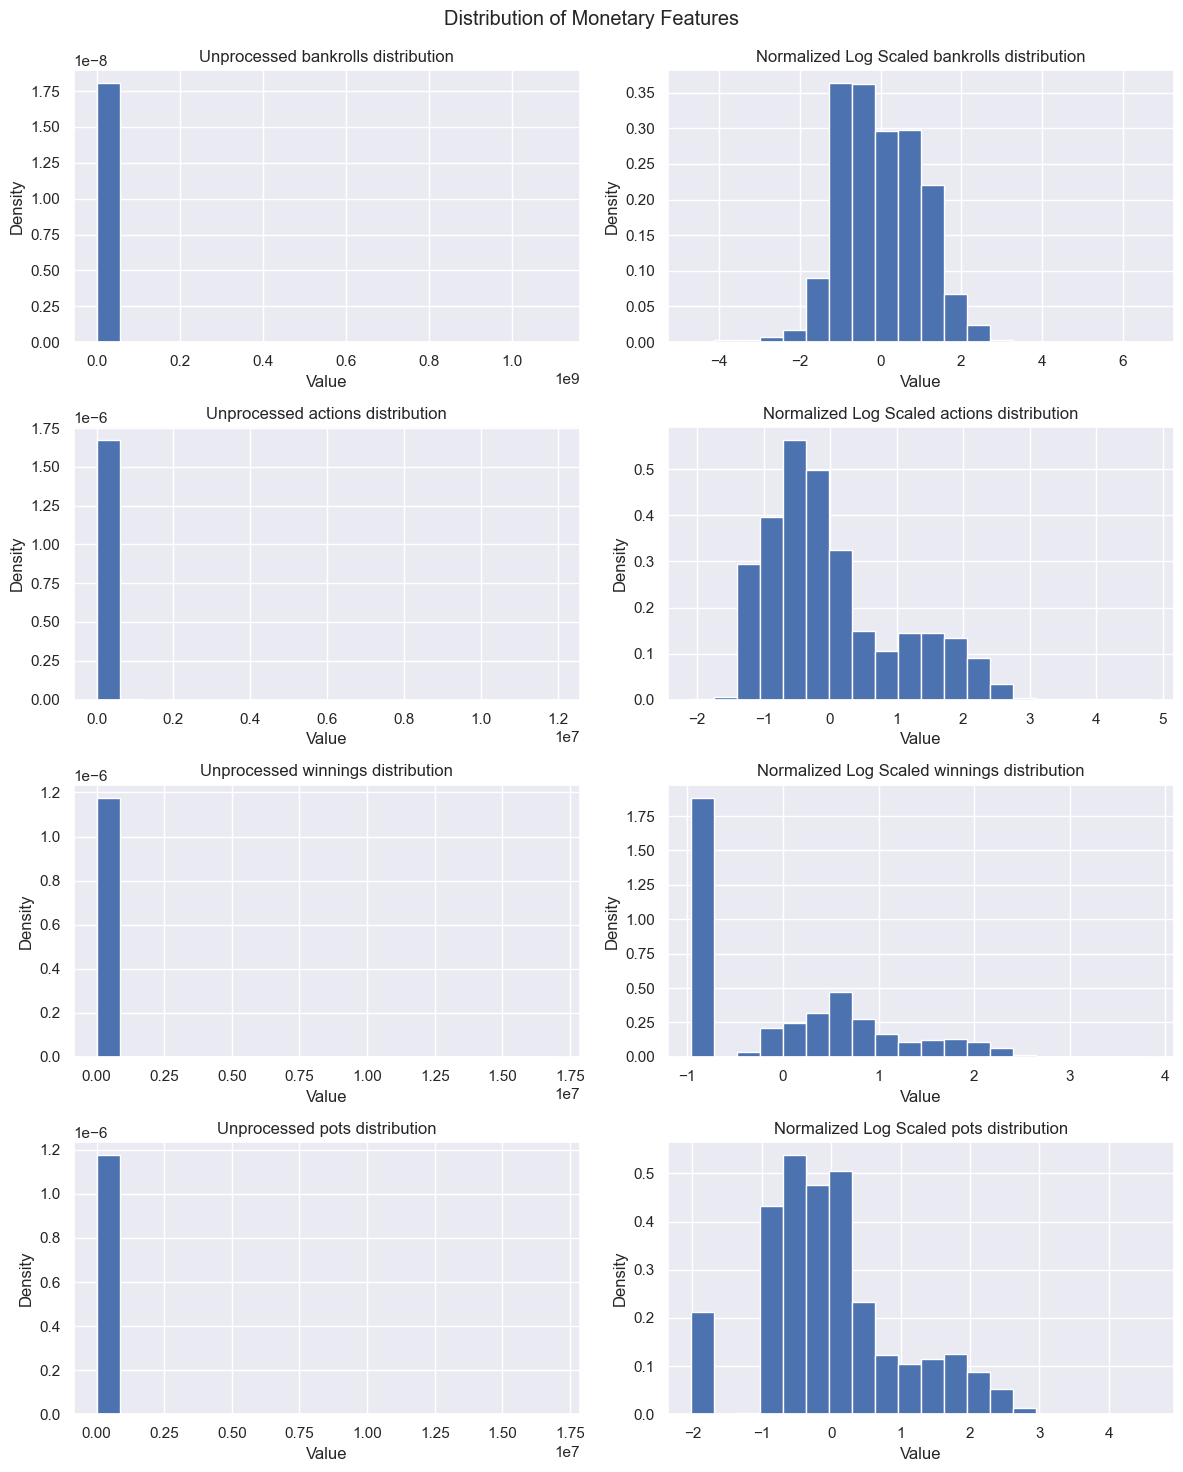

In [12]:
sns.set_theme()
fig, axes = plt.subplots(4, 2, figsize=(12,15))
for i in range(4):
    for j in range(2):
        ax = axes[i][j]
        if (i == 0):
            dataset = bankrolls
            data_str = "bankrolls"
        if (i == 1):
            dataset = actions
            data_str = "actions"
        if (i == 2):
            dataset = winnings
            data_str = "winnings"
        if(i == 3):
            dataset = pots
            data_str = "pots"
        if(j == 0):
            ax.hist(dataset, bins=20, density=True)
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.set_title(f'Unprocessed {data_str} distribution')
        if(j == 1):
            ax.hist(std_scl_arr[i], bins=20, density=True)
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.set_title(f'Normalized Log Scaled {data_str} distribution')
plt.suptitle('Distribution of Monetary Features')
plt.tight_layout()
plt.subplots_adjust(top=0.94)

In [13]:
equities = [[] for i in range(13)]
a = []
with open('data/equity.txt') as f:
    i = 0
    for line in (f):
        if(line != '\n'):
            equities[i].append(float(line.replace('\n', '')))
        else:
            i += 1

In [14]:
hands = [[] for i in range(13)]
for i, card_1 in enumerate(['A', 'K','Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']):
    for j, card_2 in enumerate(['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']):
        if(i == j): hands[i].append(card_1+card_2)
        if(i < j): hands[i].append(card_1+card_2+'s')
        if(i > j): hands[i].append(card_2+card_1+'o')

In [15]:
equities, hands = np.array(equities), np.array(hands)

In [16]:
def format_poker_hand(hand):
    # card ranks ordered from low to high
    card_order = '23456789TJQKA'
    
    # extract ranks and suits from the input
    rank1, suit1 = hand[0][0], hand[0][1]
    rank2, suit2 = hand[1][0], hand[1][1]
    
    # ensure the higher card rank is on the left side
    if card_order.index(rank1) < card_order.index(rank2):
        rank1, rank2 = rank2, rank1
        suit1, suit2 = suit2, suit1
    
    # check for pocket pairs, offsuit, or suited
    if rank1 == rank2:
        return f'{rank1}{rank2}'
    elif suit1 == suit2:
        return f'{rank1}{rank2}s'
    else:
        return f'{rank1}{rank2}o'

In [17]:
def calc_equity(card_list):
    category = format_poker_hand(card_list)
    location = np.where(hands == category)
    return equities[location[0][0], location[1][0]]

In [20]:
round_encoder = OneHotEncoder(categories=[['p', 'f', 't', 'r']])
action_encoder = OneHotEncoder(categories=[['-', 'B', 'f', 'k', 'b', 'c', 'r', 'A', 'Q', 'K']])

full_data_list = []
full_target_list = []

with open('hands_filtered.json', 'r') as file:
    i = 0
    for line in tqdm(file):
        if (i > 0): break
        data = json.loads(line)
        player_1 = data['players'][0]['bets']
        player_2 = data['players'][1]['bets']
        mixed_action_list = []
        player_list = []
        round_list = []
        for p1_round, p2_round in zip(player_1, player_2):
            j = 0
            while(True):
                try:
                    mixed_action_list.append(p1_round['actions'][j])
                    player_list.append(False)
                    round_list.append(p1_round['stage'])
                except:
                    break
                try:
                    mixed_action_list.append(p2_round['actions'][j])
                    player_list.append(True)
                    round_list.append(p2_round['stage'])
                except:
                    break
                j += 1
        mixed_action_tensor = torch.tensor(action_encoder.fit_transform(np.array(mixed_action_list).reshape(-1,1)).toarray().T)
        round_tensor = torch.tensor(round_encoder.fit_transform(np.array(round_list).reshape(-1,1)).toarray().T)
        pots_tensor = torch.tensor([((np.log(x['size'] + 1) - mean_sd_dict['pot'][0]) / mean_sd_dict['pot'][1]) for x in data['pots']])
        pots_tensor = (round_tensor.T @ pots_tensor).reshape(1, round_tensor.shape[1])

        player_tensor_1p = torch.tensor(player_list).int().reshape(1, len(player_list))
        player_tensor_2p = torch.tensor([not x for x in player_list]).int().reshape(1, len(player_list))

        
        player_1_equity = calc_equity(data['players'][0]['pocket_cards'])
        player_2_equity = calc_equity(data['players'][1]['pocket_cards'])
    
        encoded_board = torch.tensor(encode_board(data['board'], round_tensor))
        
        # money_features = np.array([((np.log(data['players'][player][feature] + 1) - mean_sd_dict[feature][0])/mean_sd_dict[feature][1])
        #                            for feature in ['bankroll', 'action', 'winnings'] for player in [0,1]]).reshape(6,1)
        # money_features = torch.tensor(np.repeat(money_features, round_tensor.shape[1], axis=1))
        
        # Removed encoded board from the front
        full_tensor_p1 = torch.concat((round_tensor, player_tensor_1p, mixed_action_tensor))
        padded_tensor_p1 = torch.nn.functional.pad(full_tensor_p1, (0, MAXIMUM_SIZE-full_tensor_p1.shape[1]), mode='constant', value=0)

        full_data_list.append(padded_tensor_p1)

        full_target_list.append((player_1_equity, player_2_equity))
conjoined_list = [(x,y) for x,y in zip(full_data_list, full_target_list)]

for i, mini_list in enumerate(torch.utils.data.random_split(conjoined_list, [0.1 for k in range(10)])):
    subfolder = 'training'
    if(i == 8):
        subfolder = 'validation'
    if(i == 9):
        subfolder = 'testing'
    print(f'Iteration {i+1}, Saving to {subfolder}')
    torch.save(list(mini_list), os.path.join('data', subfolder, f'data_list_{i}.pt'))

367055it [04:13, 1448.68it/s]


Iteration 1, Saving to training
Iteration 2, Saving to training
Iteration 3, Saving to training
Iteration 4, Saving to training
Iteration 5, Saving to training
Iteration 6, Saving to training
Iteration 7, Saving to training
Iteration 8, Saving to training
Iteration 9, Saving to validation
Iteration 10, Saving to testing


In [55]:
type(conjoined_list[1][0])

torch.Tensor

0
training
1
training
2
training
3
training
4
training
5
training
6
training
7
training
8
validation
9
testing
